In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

from collections import Counter
import os
import time


In [2]:
CONFIG = {
    # PCA
    "ENABLE_PCA": True,
    "PCA_COMPONENTS": 70,

    # Per-model PCA toggles
    "USE_PCA_FOR_KNN": True,
    "USE_PCA_FOR_SVM": True,
    "USE_PCA_FOR_DT": False,         # generally set false for DT

    # KNN from scratch
    "KNN_K": 3,
    "KNN_USE_SUBSET": False,
    "KNN_SUBSET_SIZE": 10000,

    # SVM
    "SVM_KERNEL": "rbf",
    "SVM_C": 5,
    "SVM_GAMMA": 0.05,
    "SVM_USE_SUBSET": False,
    "SVM_SUBSET_SIZE": 15000,

    # Decision Tree
    "DT_MAX_DEPTH": 20,
    "DT_MIN_SAMPLES_SPLIT": 10,

    # Misclassified
    "N_MISCLASSIFIED_SAVE": 10
}


In [3]:
BASE_OUTPUT = "/kaggle/working/outputs"
BASE_MIS_DIR = os.path.join(BASE_OUTPUT, "misclassified")

KNN_PCA_DIR = os.path.join(BASE_MIS_DIR, "knn_pca")
SVM_PCA_DIR = os.path.join(BASE_MIS_DIR, "svm_pca")
DT_DIR      = os.path.join(BASE_MIS_DIR, "decision_tree")
ENSEMBLE_DIR= os.path.join(BASE_MIS_DIR, "ensemble")

os.makedirs(KNN_PCA_DIR, exist_ok=True)
os.makedirs(SVM_PCA_DIR, exist_ok=True)
os.makedirs(DT_DIR, exist_ok=True)
os.makedirs(ENSEMBLE_DIR, exist_ok=True)

print("All outputs will be saved at:", BASE_OUTPUT)


All outputs will be saved at: /kaggle/working/outputs


In [4]:
TRAIN_PATH = "/kaggle/input/mnist-in-csv/mnist_train.csv"
TEST_PATH  = "/kaggle/input/mnist-in-csv/mnist_test.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

print("Missing values train:", train_df.isnull().sum().sum())
print("Missing values test :", test_df.isnull().sum().sum())


Train shape: (60000, 785)
Test shape : (10000, 785)
Missing values train: 0
Missing values test : 0



Train class distribution:
label
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
Name: count, dtype: int64


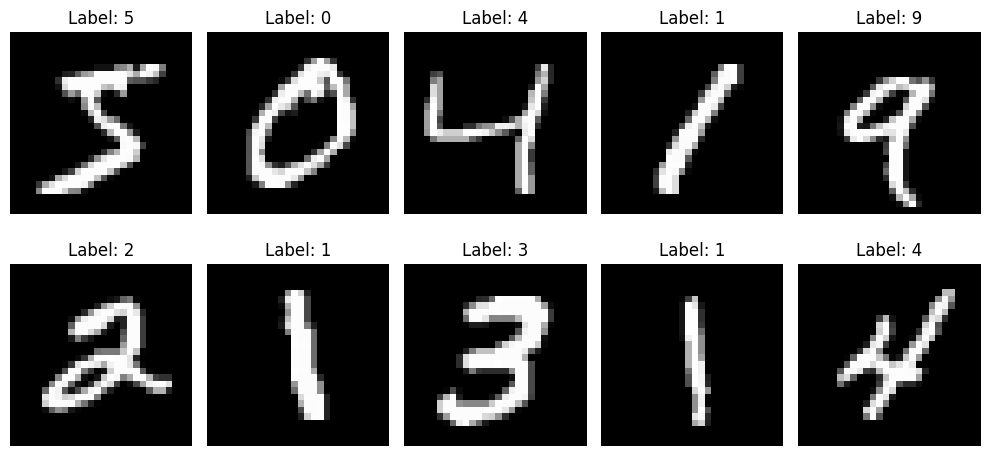

In [5]:
print("\nTrain class distribution:")
print(train_df.iloc[:, 0].value_counts().sort_index())

plt.figure(figsize=(10,5))
for i in range(10):
    img = train_df.iloc[i, 1:].values.reshape(28,28)
    label = train_df.iloc[i, 0]

    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [6]:
X_train = train_df.iloc[:, 1:].values.astype(np.float32) / 255.0
y_train = train_df.iloc[:, 0].values

X_test  = test_df.iloc[:, 1:].values.astype(np.float32) / 255.0
y_test  = test_df.iloc[:, 0].values

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


X_train: (60000, 784)
X_test : (10000, 784)


In [7]:
if CONFIG["ENABLE_PCA"]:
    pca = PCA(n_components=CONFIG["PCA_COMPONENTS"], random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca  = pca.transform(X_test)

    print("PCA Enabled ")
    print("PCA Components:", CONFIG["PCA_COMPONENTS"])
    print("Train PCA Shape:", X_train_pca.shape)
    print("Test PCA Shape:", X_test_pca.shape)
else:
    X_train_pca, X_test_pca = None, None
    print("PCA Disabled ")


PCA Enabled 
PCA Components: 70
Train PCA Shape: (60000, 70)
Test PCA Shape: (10000, 70)


In [8]:
class FastKNNFromScratch:
    def __init__(self, k=3):
        self.k = k
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_test):
        preds = []
        for x in X_test:
            distances = np.linalg.norm(self.X_train - x, axis=1)  # vectorized
            k_idx = np.argsort(distances)[:self.k]
            k_labels = self.y_train[k_idx]
            preds.append(Counter(k_labels).most_common(1)[0][0])
        return np.array(preds)


In [9]:
# This code block lets user know whether PCA is being used or not

if CONFIG["USE_PCA_FOR_KNN"] and CONFIG["ENABLE_PCA"]:
    X_knn_train_full = X_train_pca
    X_knn_test = X_test_pca
    print("KNN using PCA")
else:
    X_knn_train_full = X_train
    X_knn_test = X_test
    print("KNN using RAW pixels")

# Optional subset
if CONFIG["KNN_USE_SUBSET"]:
    X_knn_train = X_knn_train_full[:CONFIG["KNN_SUBSET_SIZE"]]
    y_knn_train = y_train[:CONFIG["KNN_SUBSET_SIZE"]]
else:
    X_knn_train = X_knn_train_full
    y_knn_train = y_train

knn_model = FastKNNFromScratch(k=CONFIG["KNN_K"])
knn_model.fit(X_knn_train, y_knn_train)

start = time.time()
y_pred_knn = knn_model.predict(X_knn_test)
knn_time = time.time() - start

print(f"KNN Accuracy: {accuracy_score(y_test, y_pred_knn):.4f} | Time: {knn_time:.2f}s")


KNN using PCA
KNN Accuracy: 0.9757 | Time: 148.49s


In [10]:
# This code block lets user know whether PCA is being used or not

if CONFIG["USE_PCA_FOR_SVM"] and CONFIG["ENABLE_PCA"]:
    X_svm_train_full = X_train_pca
    X_svm_test = X_test_pca
    print("SVM using PCA ")
else:
    X_svm_train_full = X_train
    X_svm_test = X_test
    print("SVM using RAW pixels ")

# Optional subset
if CONFIG["SVM_USE_SUBSET"]:
    X_svm_train = X_svm_train_full[:CONFIG["SVM_SUBSET_SIZE"]]
    y_svm_train = y_train[:CONFIG["SVM_SUBSET_SIZE"]]
else:
    X_svm_train = X_svm_train_full
    y_svm_train = y_train

svm_model = SVC(
    kernel=CONFIG["SVM_KERNEL"],
    C=CONFIG["SVM_C"],
    gamma=CONFIG["SVM_GAMMA"] if CONFIG["SVM_KERNEL"] == "rbf" else "scale"
)

start = time.time()
svm_model.fit(X_svm_train, y_svm_train)
y_pred_svm = svm_model.predict(X_svm_test)
svm_time = time.time() - start

print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f} | Time: {svm_time:.2f}s")


SVM using PCA 
SVM Accuracy: 0.9867 | Time: 94.46s


In [11]:
# This code block lets user know whether PCA is being used or not(its off by deafault for DT)

if CONFIG["USE_PCA_FOR_DT"] and CONFIG["ENABLE_PCA"]:
    X_dt_train = X_train_pca
    X_dt_test  = X_test_pca
    print("Decision Tree using PCA ")
else:
    X_dt_train = X_train
    X_dt_test  = X_test
    print("Decision Tree using RAW pixels ")

dt_model = DecisionTreeClassifier(
    max_depth=CONFIG["DT_MAX_DEPTH"],
    min_samples_split=CONFIG["DT_MIN_SAMPLES_SPLIT"],
    random_state=42
)

start = time.time()
dt_model.fit(X_dt_train, y_train)
y_pred_dt = dt_model.predict(X_dt_test)
dt_time = time.time() - start

print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.4f} | Time: {dt_time:.2f}s")


Decision Tree using RAW pixels 
Decision Tree Accuracy: 0.8804 | Time: 18.62s


In [12]:
ensemble_preds = np.vstack([
    y_pred_knn,
    y_pred_svm,
    y_pred_dt
])

y_pred_ensemble = np.array([
    Counter(ensemble_preds[:, i]).most_common(1)[0][0]
    for i in range(ensemble_preds.shape[1])
])

In [13]:
def evaluate_model(name, y_true, y_pred):
    """
    Prints Accuracy, Classification Report, Confusion Matrix Heatmap
    """
    acc = accuracy_score(y_true, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc


def save_misclassified(name, y_true, y_pred, X_images, save_dir, prefix, n_save=10):
    """
    Saves and displays misclassified images + saves summary CSV.
    """
    mis_idx = np.where(y_true != y_pred)[0]
    print(f"\nTotal misclassified ({name}): {len(mis_idx)}")

    # Show first N misclassified images
    show_idx = mis_idx[:n_save]

    plt.figure(figsize=(12,5))
    for i, idx in enumerate(show_idx):
        img = X_images[idx].reshape(28,28)
        t = y_true[idx]
        p = y_pred[idx]

        plt.subplot(2,5,i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"T:{t} P:{p}")
        plt.axis("off")

        # Save image
        plt.imsave(
            os.path.join(save_dir, f"{prefix}_{i}_T{t}_P{p}.png"),
            img,
            cmap="gray"
        )

    plt.tight_layout()
    plt.show()
    print(f"Saved {len(show_idx)} images to: {save_dir}")

    # Create and save misclassification summary
    mis_pairs = [(y_true[idx], y_pred[idx]) for idx in mis_idx]
    mis_df = pd.DataFrame(mis_pairs, columns=["True", "Predicted"])
    summary = mis_df.value_counts().reset_index(name="Count").sort_values("Count", ascending=False)

    summary_path = f"/kaggle/working/outputs/{prefix}_misclassification_summary.csv"
    summary.to_csv(summary_path, index=False)

    print("Saved summary CSV to:", summary_path)
    display(summary.head(10))



KNN Accuracy: 0.9757

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.98      1.00      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.96      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.97      0.97      0.97       892
           6       0.98      0.99      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.99      0.96      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



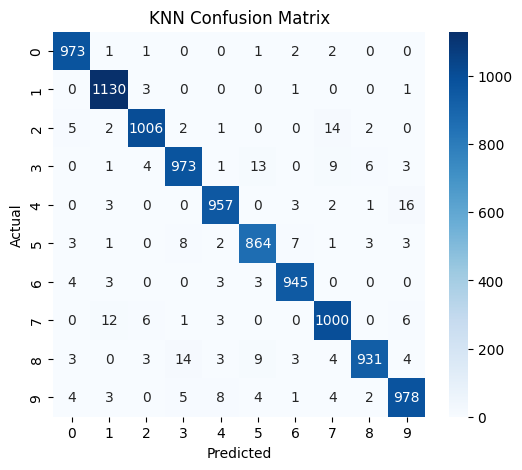


SVM Accuracy: 0.9867

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.99      0.99       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



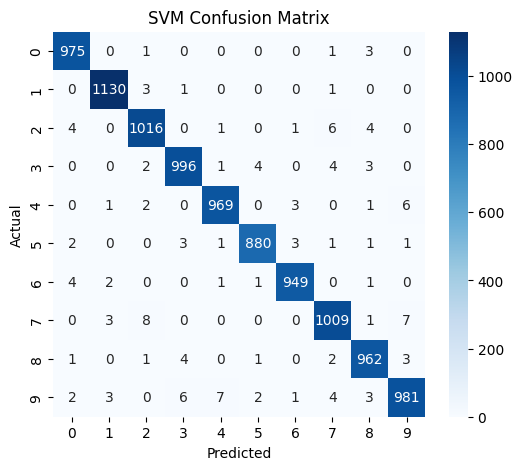


Decision Tree Accuracy: 0.8804

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       980
           1       0.95      0.97      0.96      1135
           2       0.86      0.86      0.86      1032
           3       0.84      0.86      0.85      1010
           4       0.89      0.88      0.88       982
           5       0.84      0.83      0.84       892
           6       0.89      0.89      0.89       958
           7       0.92      0.91      0.92      1028
           8       0.83      0.80      0.81       974
           9       0.87      0.86      0.86      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



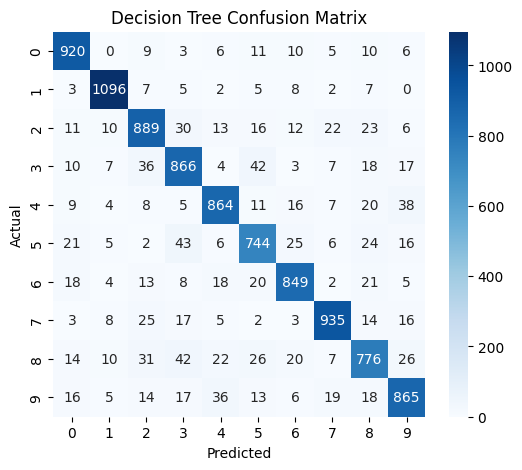


Voting Ensemble Accuracy: 0.9806

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.98      0.97      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.98      0.97       892
           6       0.99      0.99      0.99       958
           7       0.97      0.98      0.98      1028
           8       0.99      0.97      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



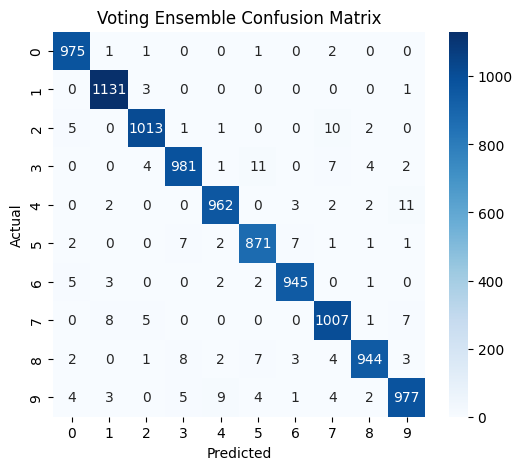

0.9806

In [14]:
evaluate_model("KNN", y_test, y_pred_knn)
evaluate_model("SVM", y_test, y_pred_svm)
evaluate_model("Decision Tree", y_test, y_pred_dt)
evaluate_model("Voting Ensemble", y_test, y_pred_ensemble)



Total misclassified (KNN): 243


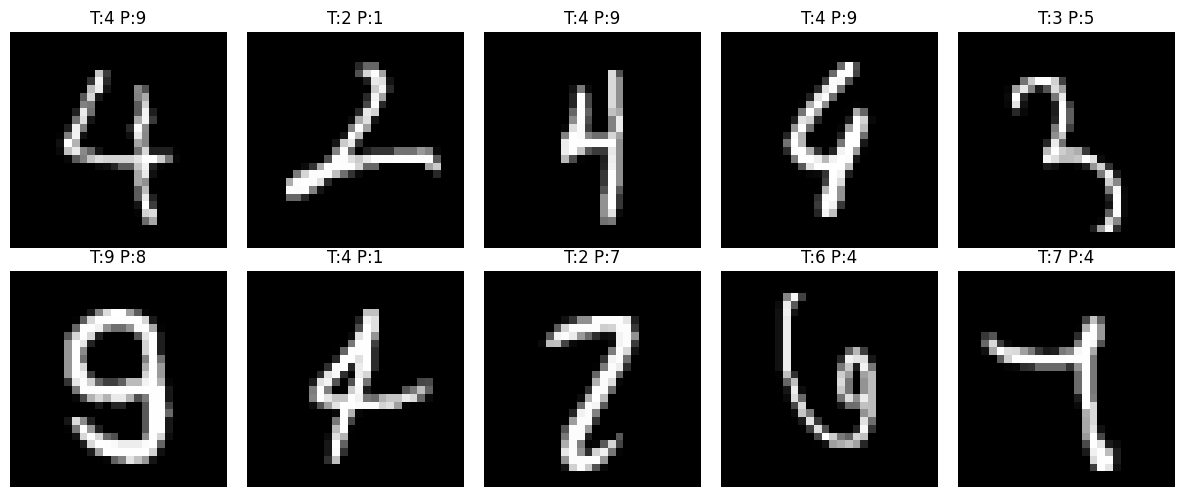

Saved 10 images to: /kaggle/working/outputs/misclassified/knn_pca
Saved summary CSV to: /kaggle/working/outputs/knn_misclassification_summary.csv


,True,Predicted,Count
0,4,9,16
1,2,7,14
2,8,3,14
3,3,5,13
4,7,1,12
5,3,7,9
6,8,5,9
7,5,3,8
8,9,4,8
9,5,6,7



Total misclassified (SVM): 133


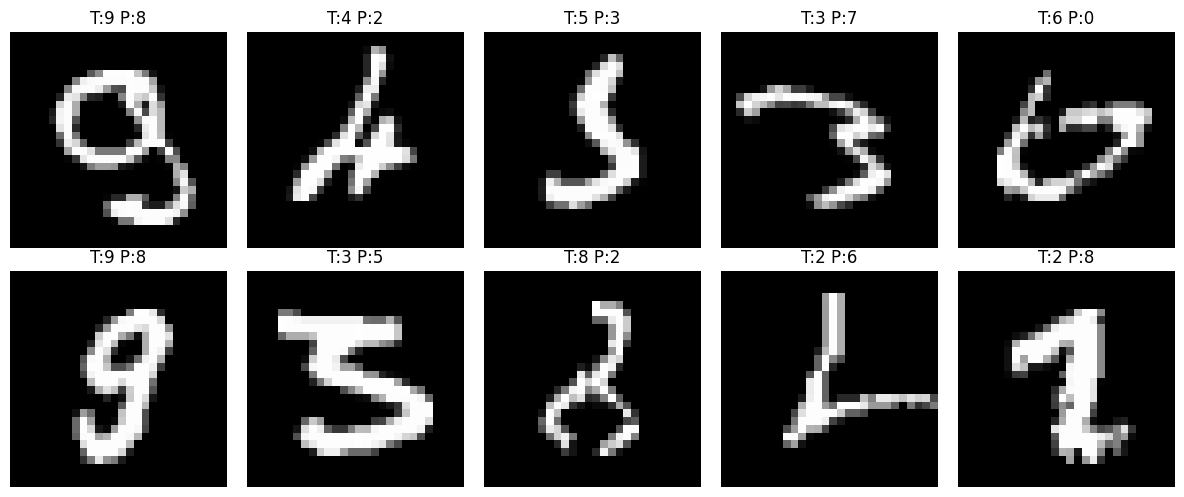

Saved 10 images to: /kaggle/working/outputs/misclassified/svm_pca
Saved summary CSV to: /kaggle/working/outputs/svm_misclassification_summary.csv


,True,Predicted,Count
0,7,2,8
1,7,9,7
2,9,4,7
3,4,9,6
4,2,7,6
5,9,3,6
6,8,3,4
7,3,5,4
8,3,7,4
9,2,0,4



Total misclassified (Decision Tree): 1196


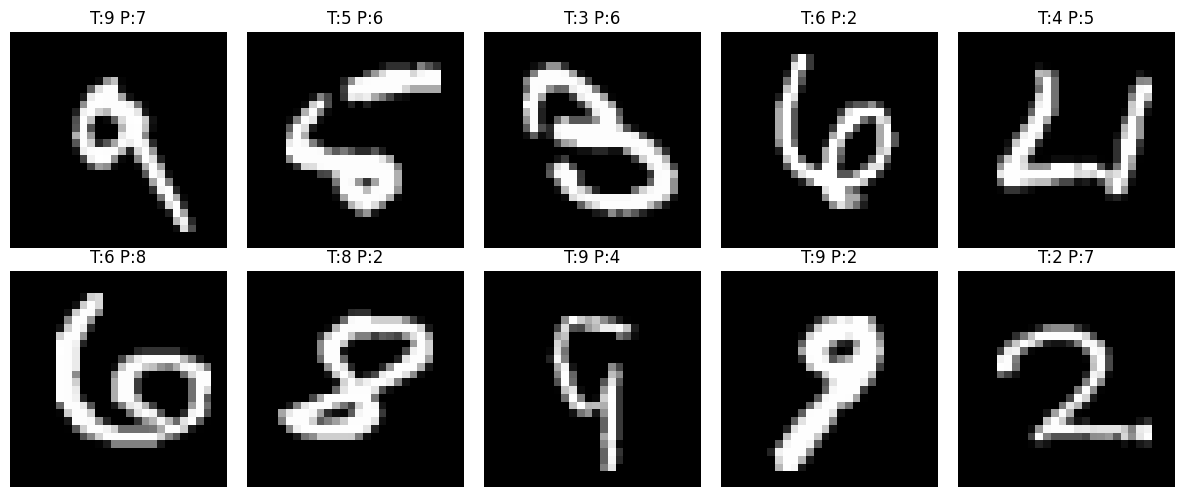

Saved 10 images to: /kaggle/working/outputs/misclassified/decision_tree
Saved summary CSV to: /kaggle/working/outputs/dt_misclassification_summary.csv


,True,Predicted,Count
0,5,3,43
1,3,5,42
2,8,3,42
3,4,9,38
4,3,2,36
5,9,4,36
6,8,2,31
7,2,3,30
8,8,5,26
9,8,9,26



Total misclassified (Ensemble): 194


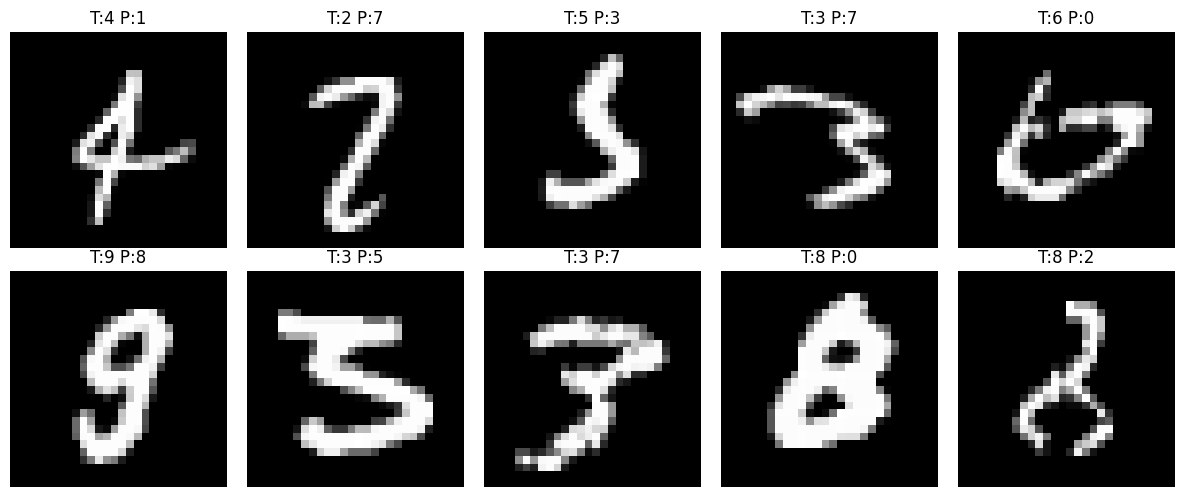

Saved 10 images to: /kaggle/working/outputs/misclassified/ensemble
Saved summary CSV to: /kaggle/working/outputs/ensemble_misclassification_summary.csv


,True,Predicted,Count
0,4,9,11
1,3,5,11
2,2,7,10
3,9,4,9
4,7,1,8
5,8,3,8
6,5,3,7
7,5,6,7
8,8,5,7
9,7,9,7


In [15]:
N_SAVE = CONFIG["N_MISCLASSIFIED_SAVE"]

save_misclassified("KNN", y_test, y_pred_knn, X_test, KNN_PCA_DIR, "knn", N_SAVE)
save_misclassified("SVM", y_test, y_pred_svm, X_test, SVM_PCA_DIR, "svm", N_SAVE)
save_misclassified("Decision Tree", y_test, y_pred_dt, X_test, DT_DIR, "dt", N_SAVE)
save_misclassified("Ensemble",y_test, y_pred_ensemble, X_test, ENSEMBLE_DIR,"ensemble", N_SAVE)

# **Flowchart**

1. Import required libraries
2. Load train.csv and test.csv
3. Data exploration
4. Dataset size + class distribution
5. Display sample images 28x28
6. Check missing values
7. Normalize pixels 0-255 to 0-1
8. Define tunable hyperparameters
9. If PCA Enabled convert the 784 dimensions to n_components dimensions
10. If PCA is not enabled Use raw 784 pixel features
11. Training of all models(KNN, SVM and Decision Tree)
12. Evaluations of all the models on the test dataset
13. Calculating the accuracy of each model
14. Confusion matrix heatmaps and classification report
15. Misclassified analysis
16. Save misclassified images
17. Save confusion-pair summary CSV
18. Final report

# **Observations and Conclusion:**

This project implements a classical machine learning pipeline to classify handwritten digits (0–9) using MNIST CSV images. The dataset was explored by viewing sample images and class distribution, and pixel values were normalized to the range 0–1. PCA was optionally applied to reduce dimensionality, improving computational efficiency for KNN and SVM. KNN was implemented fully from scratch using Euclidean distance and majority voting. A vectorized “Fast KNN” version was used instead of a loop-based simple implementation to reduce runtime while keeping the same algorithm. Simple KNN was slow on the training dataset so a FastKNN version was implemented for faster training as the training dataset was large(60000).

Among the models, SVM generally achieved the best accuracy due to stronger decision boundaries, while Decision Tree trained quickly but produced more errors due to overfitting.
The use of subset hyperparameter was not implemented(it was kept Fasle) during the final analysis for both SVM or KNN as it reduced the training samples and reduced the accuracy of the models and caused them to misclassify more digits. 

During the training of models, both Simple and Fast KNN architecure were trained with PCA. Even though PCA was enabled the simple version of KNN took longer time to train(approx. 50 mins) while the fast KNN trained within minutes. there was no noticeable difference between the accuracies of these two models with PCA enabled. The only difference was time so in this notebook only the fast KNN model is used.

Decision tree model performed the least accurately amongst these 3 models. Hyperparameter tuning was done to see the effect of various configurations. The best configuration found was the final one on which the number of misclassified digits were recorded.

Misclassifications frequently occurred between visually similar digits such as 4 and 9 or 3 and 5 3 and 8 and so on. Misclassification of digits usually happened between digits which were poorly written and the ones which have similar strokes while writing. The voting ensemble improved stability by combining predictions from multiple models. Further improvements could include tuning PCA components, optimizing hyperparameters, and applying weighted voting.

This notebook was run using kaggle and the dataset was directly attached to the input of this notebook. 